# Group Project Proposal

### Title: Ideal Days to Publish Certain News Articles

### Introduction

In a fast-paced 24-hour news cycle, it is crucial to publicize articles at the right time such that they can bring maximum impact to the audience before being overtaken and forgotten by the newer articles. For online media distribution, an effective measure of success can be the number of “shares” that a piece receives.
To this end, we would like to determine if there is an optimal day in which to publish news pieces. Our question is: given an article’s topic and the day of its publication, what is the expected number of shares? If this can be predicted, then the day can be chosen strategically.
The dataset we have chosen to work with is the Online News Popularity dataset from 2015. This dataset has 61 different attributes and outlines the genre of 39797 articles, the day of the week they were published, and the number of shares each garnered.


### Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
data <- read_csv("data/OnlineNewsPopularity.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [3]:
set.seed(1234)
publishing_split <- initial_split(data, prop = 0.6, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

named_data <- publishing_train %>%
    rename(
        Monday = weekday_is_monday,
        Tuesday = weekday_is_tuesday,
        Wednesday = weekday_is_wednesday,
        Thursday = weekday_is_thursday,
        Friday = weekday_is_friday,
        Saturday = weekday_is_saturday,
        Sunday = weekday_is_sunday,
        Lifestyle = data_channel_is_lifestyle,
        Entertainment =  data_channel_is_entertainment,
        Business = data_channel_is_bus,
        Society_and_Medicine =  data_channel_is_socmed,
        Technology =  data_channel_is_tech,
        World =  data_channel_is_world,
        Shares = shares
    )
#It didn't work when all in one pipe, I have no idea why. This seems to work though
tidy_data <- named_data %>%
    pivot_longer(cols =  Lifestyle : World, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    pivot_longer(cols =   Monday:Sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Genre_Present == 1) %>%
    filter(Day_Present == 1) %>%
    mutate(abs_pos_neg_ratio = (global_rate_positive_words*avg_positive_polarity)/abs(global_rate_negative_words*avg_negative_polarity)) %>%
    filter(global_rate_positive_words != 0 & global_rate_negative_words != 0) %>%
    select(Genre, Day_Of_Week, Shares,  abs_pos_neg_ratio)

head(tidy_data)

day_table <- tidy_data %>%
    group_by(Day_Of_Week) %>%
    summarize(total_articles=n(), avg_shares=mean(Shares),abs_pos_neg_ratio = mean(abs_pos_neg_ratio) )
day_table

genre_table <- tidy_data %>%
    group_by(Genre) %>%
    summarize(total_articles=n(), avg_shares=mean(Shares),abs_pos_neg_ratio = mean(abs_pos_neg_ratio) )
genre_table

Genre,Day_Of_Week,Shares,abs_pos_neg_ratio
<chr>,<chr>,<dbl>,<dbl>
Entertainment,Monday,593,3.606061
Business,Monday,711,6.644338
Technology,Monday,855,1.977800
Technology,Monday,891,9.748504
Technology,Monday,3600,6.800000
World,Monday,710,1.611429


`summarise()` ungrouping output (override with `.groups` argument)



Day_Of_Week,total_articles,avg_shares,abs_pos_neg_ratio
<chr>,<int>,<dbl>,<dbl>
Friday,2707,2646.967,5.474310
Monday,3246,2890.522,5.672414
Saturday,1195,3492.825,6.310612
Sunday,1256,3523.873,5.708910
Thursday,3563,2774.927,5.703341
Tuesday,3567,2730.887,5.694678
Wednesday,3598,2708.387,5.793929


`summarise()` ungrouping output (override with `.groups` argument)



Genre,total_articles,avg_shares,abs_pos_neg_ratio
<chr>,<int>,<dbl>,<dbl>
Business,3528,2859.335,6.897001
Entertainment,4003,2803.682,4.778099
Lifestyle,1221,3834.812,6.461264
Society_and_Medicine,1330,3721.685,6.847004
Technology,4204,3070.612,7.164596
World,4846,2201.596,3.889523


`summarise()` regrouping output by 'Genre' (override with `.groups` argument)



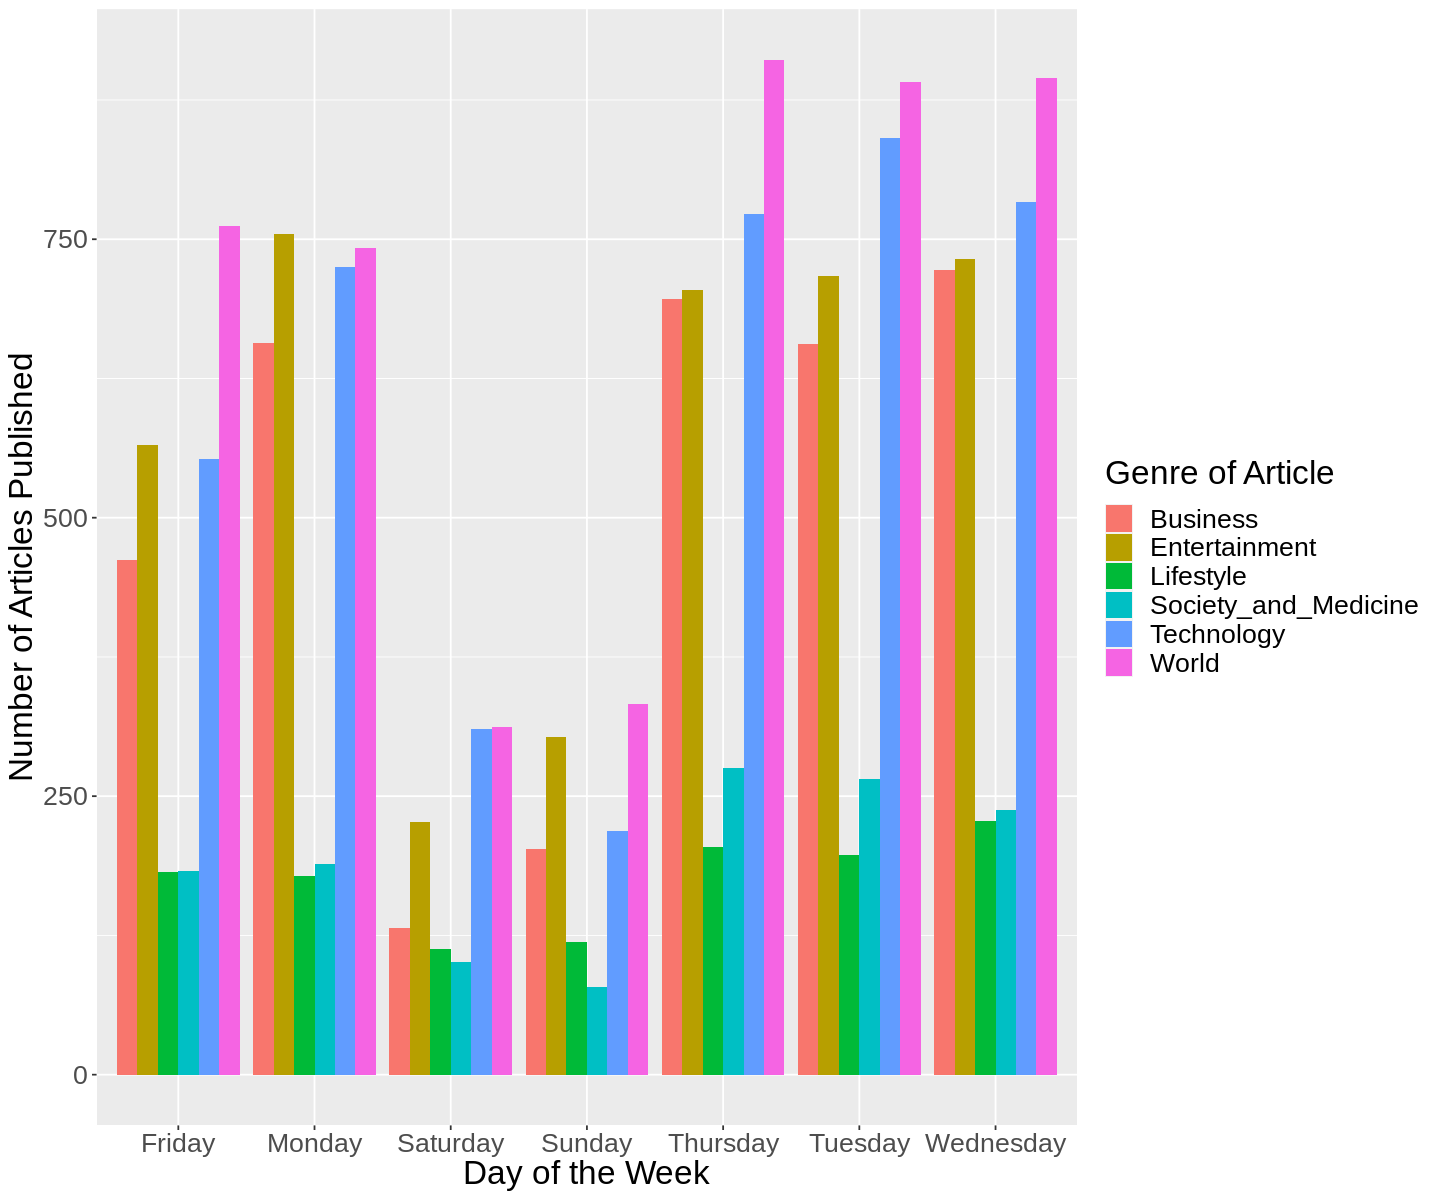

In [4]:
publish_data <- tidy_data %>%
    group_by(Genre, Day_Of_Week) %>%
    summarize(n = n())


options(repr.plot.width = 12, repr.plot.height = 10)
publish_plot <- publish_data %>%
    ggplot(aes(x = Day_Of_Week, y = n, fill = Genre)) + 
    geom_bar(stat = 'identity', position = "dodge") +
    xlab("Day of the Week") +
    ylab("Number of Articles Published") +
    labs(fill = "Genre of Article") +
    theme(text = element_text(size = 20))

publish_plot

This visualization allows us to easily compare and contrast the frequency of which Genres of Article are published for each Day of the Week respectively. This is necessary for our data analysis to maximize the effectiveness of the publishing time for an article and to identify any over-publishing of article types on specific dates.

In [5]:
share_data_avg <- tidy_data %>%
    group_by(Day_Of_Week, Genre) %>%
    summarize(n = n(), Average_Shares_Per_Article = mean(Shares)/n)

head(share_data_avg)

`summarise()` regrouping output by 'Day_Of_Week' (override with `.groups` argument)



Day_Of_Week,Genre,n,Average_Shares_Per_Article
<chr>,<chr>,<int>,<dbl>
Friday,Business,462,5.477460
Friday,Entertainment,565,4.667432
Friday,Lifestyle,182,14.365958
Friday,Society_and_Medicine,183,19.497148
Friday,Technology,553,5.415132
Friday,World,762,2.964734


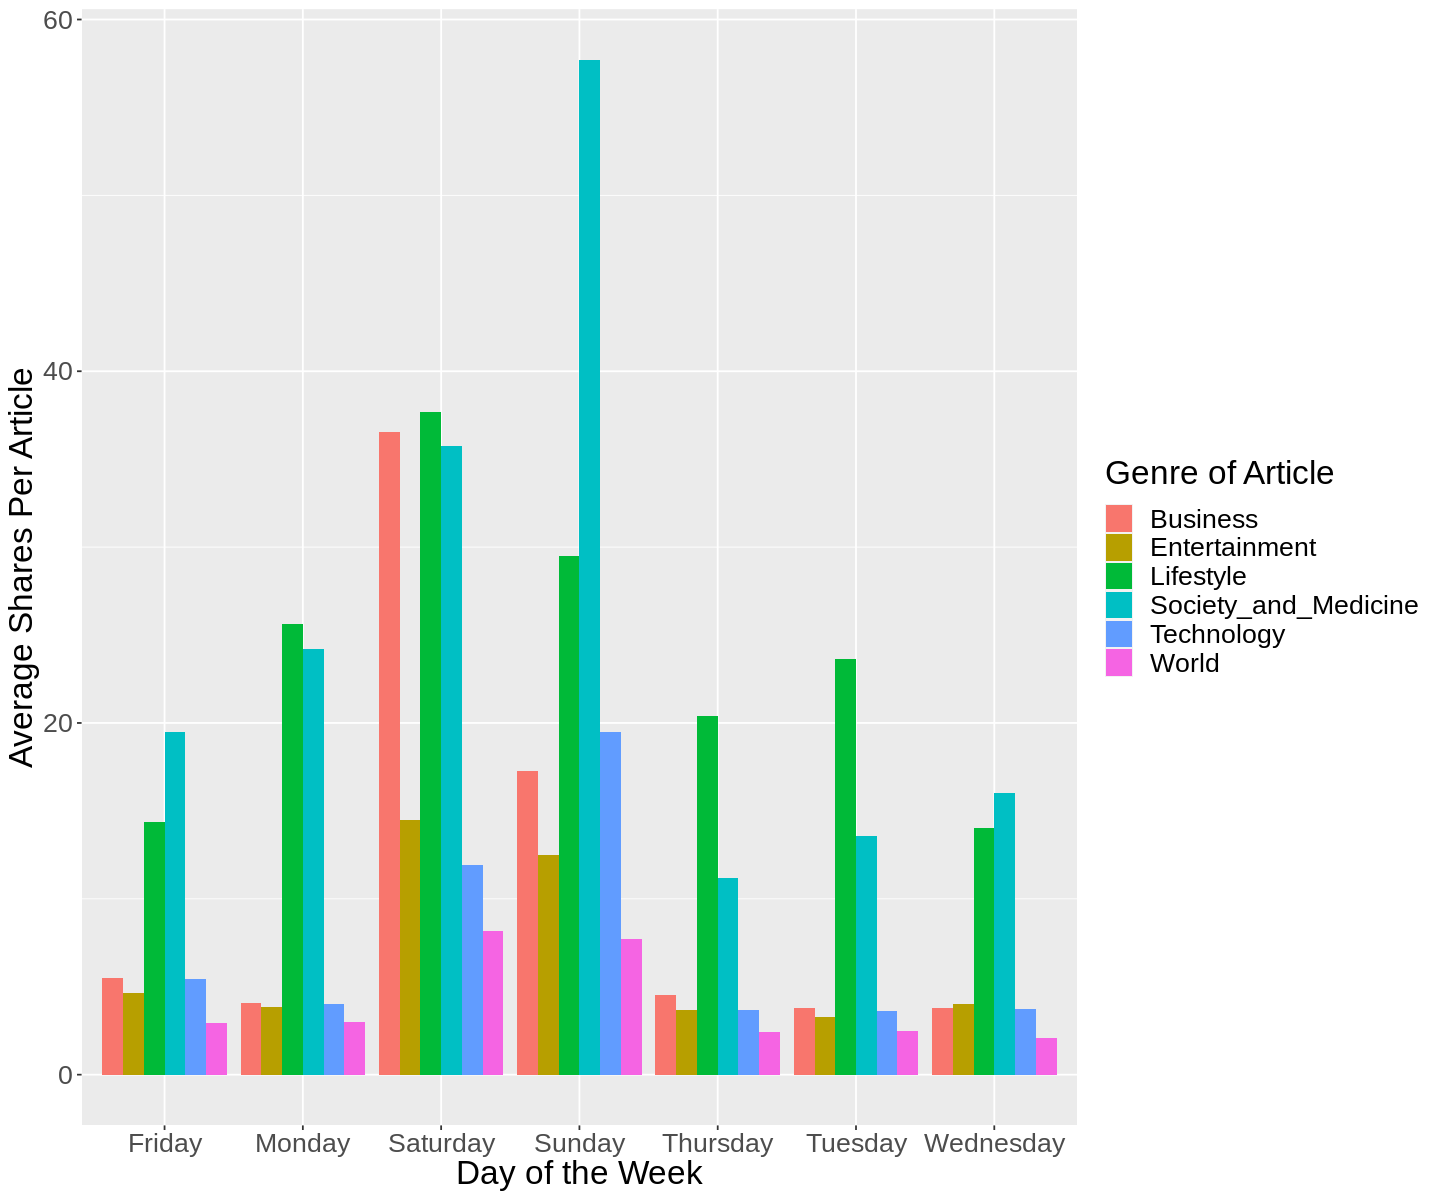

In [6]:

options(repr.plot.width = 12, repr.plot.height = 10)
share_plot <- share_data_avg %>%
    ggplot(aes(x = Day_Of_Week, y = Average_Shares_Per_Article, fill = Genre)) + 
    geom_bar(stat = 'identity', position = "dodge") +
    xlab("Day of the Week") +
    ylab("Average Shares Per Article") +
    labs(fill = "Genre of Article") +
    theme(text = element_text(size = 20))

share_plot

This visualization allows us to compare and contrast the Average Shares Per Article for every Genre of Article for each Day of the Week. This can provide us with an estimate on which day of the week to publish each article genre for the highest success in share rates.

In [7]:
share_data_totals <- tidy_data %>%
    group_by(Day_Of_Week, Genre) %>%
    summarize(n = n(), Shares = sum(Shares))

head(share_data_totals)

`summarise()` regrouping output by 'Day_Of_Week' (override with `.groups` argument)



Day_Of_Week,Genre,n,Shares
<chr>,<chr>,<int>,<dbl>
Friday,Business,462,1169131
Friday,Entertainment,565,1489961
Friday,Lifestyle,182,475858
Friday,Society_and_Medicine,183,652940
Friday,Technology,553,1655996
Friday,World,762,1721455


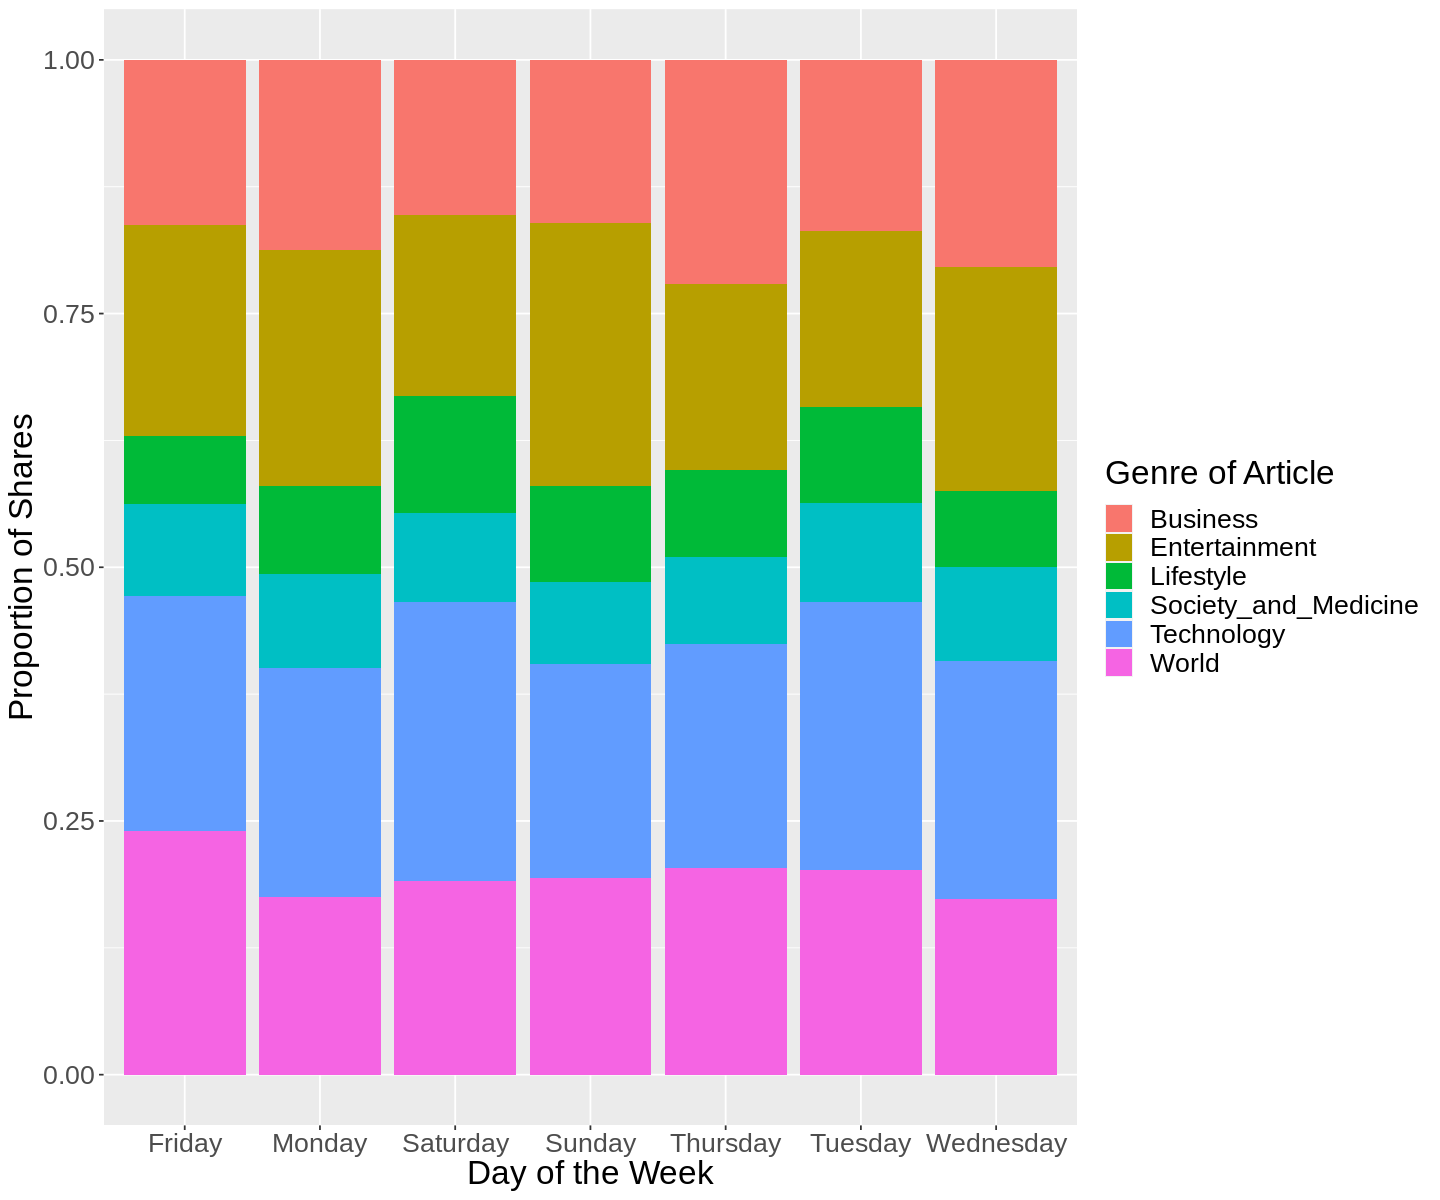

In [8]:

options(repr.plot.width = 12, repr.plot.height = 10)
share_plot_proportion <- share_data_totals %>%
    ggplot(aes(x = Day_Of_Week, y = Shares, fill = Genre)) + 
    geom_bar(stat = 'identity', position = "fill") +
    xlab("Day of the Week") +
    ylab("Proportion of Shares") +
    labs(fill = "Genre of Article") +
    theme(text = element_text(size = 20))

share_plot_proportion

This visualization allows us to see the proportions of all genres of articles. From this visualization, we can tell which genre of the article is the most popular compared to the other genres.

In [9]:
daily_totals <- share_data_totals %>%
    group_by(Day_Of_Week) %>%
    summarize(Total_Shares = sum(Shares))
daily_totals

`summarise()` ungrouping output (override with `.groups` argument)



Day_Of_Week,Total_Shares
<chr>,<dbl>
Friday,7165341
Monday,9382636
Saturday,4173926
Sunday,4425984
Thursday,9887065
Tuesday,9741075
Wednesday,9744778


### Methods

We will begin by analyzing the dataset in its original form to correctly import it into Jupyter notebooks. We will use Github to share our group contributions. 
We will tidy the dataset to ensure that columns represent variables, rows represent observations, and cells contain single values. Next, we will use the variable ‘Day of the Week’ juxtaposed (individually) with the variables of  ‘Proportion of Shares’, ‘Average Shares per Article’, and ‘Number of Articles Published’ to create visualizations of the data (coloured graphs). We will study the data visualizations in order to draw information about article sharing and publishing on each day of the week, separated by topic.

### Expected Outcomes and Significance

We expect to determine whether the day of the week will have an impact on the type of news article that people are more likely to read or share. The findings can be used to optimize the efficiency of when news articles should be published so that they are not overtaken and forgotten as newer topics get published. Future questions may include: How often should newspaper companies publish new articles? Is it more ideal to publish during the weekdays compared to weekends? 
